## 0. Import necessary modules

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Data Manipulation
import numpy as np
import pandas as pd
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (common)
from sklearn.externals import joblib
from keras.models import load_model

import random

In [37]:
pd.set_option('display.max_columns', 60)

In [38]:
%matplotlib inline

## 1. Load data

In [39]:
# Local paths to data
proc_data_PATH = './processed_data/'
models_PATH = './models/'

In [74]:
with open(proc_data_PATH + 'proc_dataframes_no_dummies.pkl', 'rb') as f:
    db_20k_imp_nd,db_10k_imp_nd = pickle.load(f)

In [40]:
with open(proc_data_PATH + 'proc_dataframes.pkl', 'rb') as f:
    db_20k_final,db_10k_final = pickle.load(f)

In [41]:
with open(proc_data_PATH + 'train_test_sets.pkl', 'rb') as f:
    X_train_f,y_train_f,X_test_f,y_test_f = pickle.load(f)

In [42]:
with open(proc_data_PATH + 'train_test_sets_logged.pkl', 'rb') as f:
    X_train_f_log,y_train_f_log,X_test_f_log,y_test_f_log = pickle.load(f)

First we need to take logs of the continuous features for DB_10000 like we did for DB_20000

In [43]:
cont_ft = ['Living Area (m^2)','House Price','Income','House Insurance','Pension Plan','Credit','Savings']
db_10k_final_log = db_10k_final.copy()
for column in cont_ft:
    db_10k_final_log[column] = db_10k_final[column].apply(lambda x: np.log(x) if x > 0 else 0)

## 2. Load models

In [44]:
# Standard Scaler
sc = joblib.load(models_PATH + 'standard_scaler.joblib') 

In [45]:
lr_best = joblib.load(models_PATH + 'lr_best.joblib') 
svc_best = joblib.load(models_PATH + 'svc_best.joblib') 
rf_best = joblib.load(models_PATH + 'rf_best.joblib')
basic_xgb = joblib.load(models_PATH + 'basic_xgb.joblib')
nn_clf = load_model(models_PATH + 'nn_clf_log_std.h5')

lr_chosen = joblib.load(models_PATH + 'lr_chosen.joblib') 

## 3. Revenue from already contacted clients

Dataset DB_20000 contains data from 20000 clients who where previously contacted, including the premium they were offered and wether they bought it or not. We will first compute what revenue was obtained from them and use it as a benchmark for the results of our optimized predictive models.

In [46]:
rev_20k = db_20k_final[db_20k_final['Sales'] == 1]['Premium Offered'].sum()
number_of_sales = db_20k_final[db_20k_final['Sales'] == 1]['Premium Offered'].count()
mean_rev_20k = rev_20k / 20000
mean_rev_20k_positive = rev_20k / number_of_sales

print('Revenue from already contacted customers (20000 people): ',rev_20k, ' monetary units')
print('Average revenue per customer (considering all 20000): ',mean_rev_20k, ' monetary units/customer')
print('Average revenue per customer (considering ' + str(number_of_sales) + ' buyers): ',mean_rev_20k_positive, ' monetary units/customer')

Revenue from already contacted customers (20000 people):  24082.4  monetary units
Average revenue per customer (considering all 20000):  1.20412  monetary units/customer
Average revenue per customer (considering 1715 buyers):  14.042215743440234  monetary units/customer


- There were 1715 buyers in DB_20000 datasets.
- Given the premiums they bought, a revenue of 24082.5 monetary units was obtained
- That implies an average revenue per customer of 14.04 monetary units

In [47]:
db_20k_final[db_20k_final['Sales'] == 1]['Premium Offered'].value_counts()

14.50    924
11.12    615
21.85    176
Name: Premium Offered, dtype: int64

## 3. Evaluate models on DB_10000

We will consider two cases:
- Assigning random premium values to each customer to see what kind of revenue could be obtained this way
- Optimizing the premium for each individual client, that is, looking for the highest possible premium value we can offer them so they are still willing to buy (the willingness to buy needs to be predefined by imposing a probability threshold to the predicitive models).

#### Probability Threshold for Positive Sale
We will take a probability over 0.5 output by our models as the threshold over wiche we get a sale.

In [48]:
min_threshold = 0.5

In [49]:
def revenue_results(prems):
    rev = sum(prems)
    number_of_sales = len(prems)
    mean_rev = rev / 10000
    mean_rev_positive = rev / number_of_sales
    
    print('Revenue from already contacted customers (10000 people): ',rev, ' monetary units')
    print('Average revenue per customer (considering all 10000): ',mean_rev, ' monetary units/customer')
    print('Average revenue per customer (considering ' + str(number_of_sales) + ' buyers): ',mean_rev_positive, ' monetary units/customer')

#### Opmization range

We will try premium values from 1 monetary unit to 200 monetary units, that is, much lower and much much higher than what is proposed, to see how far the models can push this variable and still get a decent probability of positive sale.

These limits (specially the upper one) must be regarded with care, since our models are not perfect and they behave erratically sometimes when extrapolating to new regions.

In [55]:
def prem2rev(data,model,min_threshold,sc=None,random_rep=100):
    ''''''
    # Random Premium
    # Initialize the column Premium Offered
    data['Premium Offered'] = 33
    
    rand_revs = []
    for i in range(random_rep):
        rand_premium = [random.choice(list(np.linspace(1,200,199))) for i in range(data.shape[0])]
        data['Premium Offered'] = rand_premium
        # Apply scaler if needed
        if sc is not None:
            data_array = sc.transform(data)
        else:
            data_array = data.values
        probas = model.predict_proba(data_array)[:,1]

        rand_rev = 0
        for prem,proba in zip(rand_premium,list(probas)):
            if proba > min_threshold:
                rand_rev += prem

        rand_revs.append(rand_rev)
        
    # Optimized Premium
    dict_prem_lr = {}   
    
    for premium in np.linspace(1,200,199):
        data['Premium Offered'] = premium
        # Apply scaler if needed
        if sc is not None:
            data_array = sc.transform(data)
        else:
            data_array = data.values
        probas = model.predict_proba(data_array)
        dict_prem_lr['Prem_' + str(premium)] = list(probas[:,1])
    
    prem_lr = pd.DataFrame(data=dict_prem_lr)
    c2c = prem_lr[prem_lr['Prem_1.0'] > min_threshold]
    
    opt_clients = []
    opt_premiums = []
    for idx, row in c2c.iterrows():
        m = row > min_threshold
        opt_clients.append(idx)
        opt_premiums.append(float(row.loc[m].index.tolist()[-1].split('_')[-1]))
    
    # Preview results
    print('Minimun revenue from random premiums: ', min(rand_revs), ' monetary units')
    print('Maximum revenue from random premiums: ', max(rand_revs), ' monetary units')
    print('Mean revenue from random premiums: ', np.mean(rand_revs), ' monetary units')
    print('Revenue from optimized premiums: ', sum(opt_premiums), ' monetary units')
    print('Number of clients who bought an optimized premium: ', len(opt_premiums))
    
    return rand_revs, opt_clients, opt_premiums

### 3.1 Logistic Regression

In [56]:
rand_revs_lr_best, opt_clients_lr_best, opt_premiums_lr_best = prem2rev(data=db_10k_final_log,
                                                                        model=lr_best,
                                                                        min_threshold=min_threshold,
                                                                        sc=sc)

Minimun revenue from random premiums:  6671.878787878785  monetary units
Maximum revenue from random premiums:  9268.77272727273  monetary units
Mean revenue from random premiums:  8222.078585858582  monetary units
Revenue from optimized premiums:  30705.126262626287  monetary units
Number of clients who bought an optimized premium:  432


In [57]:
revenue_results(opt_premiums_lr_best)

Revenue from already contacted customers (10000 people):  30705.126262626287  monetary units
Average revenue per customer (considering all 10000):  3.0705126262626288  monetary units/customer
Average revenue per customer (considering 432 buyers):  71.07668116348678  monetary units/customer


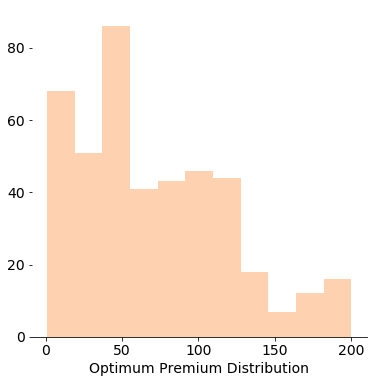

In [100]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(pd.Series(opt_premiums_lr_best),kde=False,color=sns.color_palette("Oranges", 5)[2],ax=ax)

ax.set_xlabel('Optimum Premium Distribution', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig("opt_prem_dist.svg", bbox_inches='tight')

Our logistic regression captures 432 buyers and offers most of them premiums in a range from 1 to 100 monetary units. There are also some clients who are offered premiums from 100 to 200 monetary units which are willing to take them according to the computed sale probabilities.

Overall we get 30705 monetary units, which is much better than the result obtained by offering random premiums (between 6672 and 9269 monetary units).

We get 72 monetary units per customer on average, which is much higher than what we got for already contacted clients (14 mu).

Given the behavior of known customers and the premiums they have offered so far, this results might be too optimistic. The model has probably found there are some clients who have a very high sale probability based on other features apart from Premium Offered (features that have more weight) and it takes a really large value for the former to take this probability below 0.5.

In reality, it probably would not be a good idea to offer products at a price that is 10 times higher than the most expensive one we were selling so far.

In [95]:
opt_revs_df = pd.DataFrame(data={'Revs':rand_revs_lr_best})
opt_revs_df['type'] = 'Random'
opt_revs_df.loc[-1] = [30705, 'Optimized']
opt_revs_df.tail()

,Revs,type
96,8054.661616,Random
97,8573.267677,Random
98,9104.939394,Random
99,7670.792929,Random
-1,30705.000000,Optimized


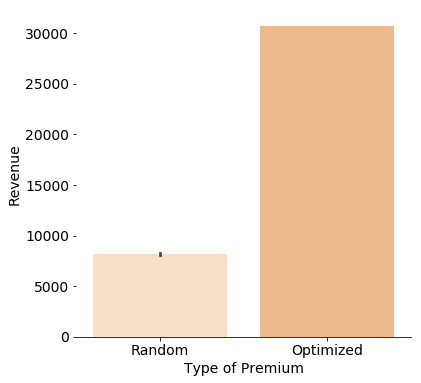

In [98]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x = 'type',y = 'Revs', data = opt_revs_df,palette=sns.color_palette("Oranges", 5),ax=ax)

ax.set_xlabel('Type of Premium', fontsize=14)
ax.set_ylabel('Revenue', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig("random_vs_opt_rev.svg", bbox_inches='tight')

### 3.2 Random Forest

In [23]:
rand_revs_rf_best, opt_clients_rf_best, opt_premiums_rf_best = prem2rev(data=db_10k_final,
                                                                        model=rf_best,
                                                                        min_threshold=min_threshold)

Minimun revenue from random premiums:  32363.924242424244  monetary units
Maximum revenue from random premiums:  36456.47474747474  monetary units
Mean revenue from random premiums:  34169.72429292929  monetary units
Revenue from optimized premiums:  68067.02020202015  monetary units
Number of clients who bought an optimized premium:  403


In [35]:
revenue_results(opt_premiums_rf_best)

Revenue from already contacted customers (10000 people):  68067.02020202015  monetary units
Average revenue per customer (considering all 10000):  6.806702020202016  monetary units/customer
Average revenue per customer (considering 403 buyers):  168.9007945459557  monetary units/customer


200.000000    335
18.085859      41
12.055556      27
dtype: int64


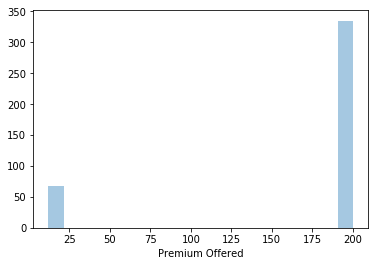

In [44]:
print(pd.Series(opt_premiums_rf_best).value_counts())
sns.distplot(pd.Series(opt_premiums_rf_best),kde=False)
_ = plt.xlabel('Premium Offered')

Our random forest captures 403 positive buyers, which is great. However, it assigns premiums of 200 monetary units (the highest possible value in our range) to most of them.

This is not surprising, given that tree-based algorithms are not well suited for extrapolation. Given that it was trained on premiums below 21 monetary units, the algorithm concludes that any client willing to pay a premium as high as that, will be also be willing to pay any higher premium, which leads to unrealistic results.

### 3.3 Support Vector Machine

In [28]:
rand_revs_svc_best, opt_clients_svc_best, opt_premiums_svc_best = prem2rev(data=db_10k_final_log,
                                                                        model=svc_best,
                                                                        min_threshold=min_threshold,
                                                                        sc=sc)

C:\Users\PcCom\Anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\PcCom\Anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


Minimun revenue from random premiums:  965887.7070707091  monetary units
Maximum revenue from random premiums:  991505.7979798027  monetary units
Mean revenue from random premiums:  977579.3466666706  monetary units
Revenue from optimized premiums:  68400.0  monetary units
Number of clients who bought an optimized premium:  342


In [45]:
revenue_results(opt_premiums_svc_best)

Revenue from already contacted customers (10000 people):  68400.0  monetary units
Average revenue per customer (considering all 10000):  6.84  monetary units/customer
Average revenue per customer (considering 342 buyers):  200.0  monetary units/customer


200.0    342
dtype: int64


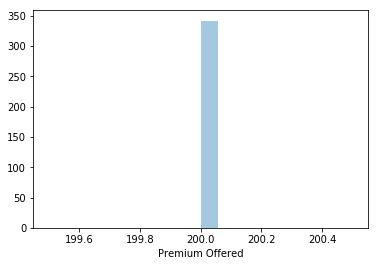

In [46]:
print(pd.Series(opt_premiums_svc_best).value_counts())
sns.distplot(pd.Series(opt_premiums_svc_best),kde=False)
_ = plt.xlabel('Premium Offered')

The SVC model (with rbf kernel) behaves very poorly as well in this optimization problem. Similarly to the Random Forest, it is capable of offering the highest possible premium to a group of 342 people.

We already saw at the EDA section that the probability of sale strongly depends on some features, and 'Premium Offered' was not one of them. This makes some models assign a positive sale to some individuals based on the former features, no matter what the "non-important" features are.

### 3.4 XGBoost

In [47]:
def prem2rev_xgb(data,model,min_threshold,sc=None,random_rep=100):
    ''''''
    # Random Premium
    # Initialize the column Premium Offered
    data['Premium Offered'] = 33
    
    rand_revs = []
    for i in range(random_rep):
        rand_premium = [random.choice(list(np.linspace(1,200,199))) for i in range(data.shape[0])]
        data['Premium Offered'] = rand_premium
        probas = model.predict_proba(data)[:,1]

        rand_rev = 0
        for prem,proba in zip(rand_premium,list(probas)):
            if proba > min_threshold:
                rand_rev += prem

        rand_revs.append(rand_rev)
        
    # Optimized Premium
    dict_prem_lr = {}
    
    # Apply scaler if needed
    
    for premium in np.linspace(1,200,199):
        data['Premium Offered'] = premium
        probas = model.predict_proba(data)
        dict_prem_lr['Prem_' + str(premium)] = list(probas[:,1])
    
    prem_lr = pd.DataFrame(data=dict_prem_lr)
    c2c = prem_lr[prem_lr['Prem_1.0'] > min_threshold]
    
    opt_clients = []
    opt_premiums = []
    for idx, row in c2c.iterrows():
        m = row > min_threshold
        opt_clients.append(idx)
        opt_premiums.append(float(row.loc[m].index.tolist()[-1].split('_')[-1]))
    
    # Preview results
    print('Minimun revenue from random premiums: ', min(rand_revs), ' monetary units')
    print('Maximum revenue from random premiums: ', max(rand_revs), ' monetary units')
    print('Mean revenue from random premiums: ', np.mean(rand_revs), ' monetary units')
    print('Revenue from optimized premiums: ', sum(opt_premiums), ' monetary units')
    print('Number of clients who bought an optimized premium: ', len(opt_premiums))
    
    return rand_revs, opt_clients, opt_premiums

In [48]:
rand_revs_basic_xgb, opt_clients_basic_xgb, opt_premiums_basic_xgb = prem2rev_xgb(data=db_10k_final,
                                                                        model=basic_xgb,
                                                                        min_threshold=min_threshold)

Minimun revenue from random premiums:  29122.772727272735  monetary units
Maximum revenue from random premiums:  33622.383838383845  monetary units
Mean revenue from random premiums:  31648.34404040404  monetary units
Revenue from optimized premiums:  62600.0  monetary units
Number of clients who bought an optimized premium:  313


In [49]:
revenue_results(opt_premiums_basic_xgb)

Revenue from already contacted customers (10000 people):  62600.0  monetary units
Average revenue per customer (considering all 10000):  6.26  monetary units/customer
Average revenue per customer (considering 313 buyers):  200.0  monetary units/customer


200.0    313
dtype: int64


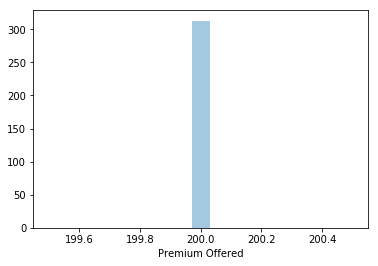

In [50]:
print(pd.Series(opt_premiums_basic_xgb).value_counts())
sns.distplot(pd.Series(opt_premiums_basic_xgb),kde=False)
_ = plt.xlabel('Premium Offered')

Results look like those of the Random Forest model, which makes sense given that XGBoost is another tree-based algorithm. It is unfortunate that models with such predictive power might result useless for optimization if our range of values goes out of the bounds of our training data.

### 3.5 Neural Network

In [53]:
def prem2rev_nn(data,model,min_threshold,sc=None,random_rep=100):
    ''''''
    # Random Premium
    # Initialize the column Premium Offered
    data['Premium Offered'] = 33
    
    rand_revs = []
    for i in range(random_rep):
        rand_premium = [random.choice(list(np.linspace(1,200,199))) for i in range(data.shape[0])]
        data['Premium Offered'] = rand_premium
        # Apply scaler if needed
        if sc is not None:
            data_array = sc.transform(data)
        else:
            data_array = data.values     
        probas = model.predict(data_array)[:,1]

        rand_rev = 0
        for prem,proba in zip(rand_premium,list(probas)):
            if proba > min_threshold:
                rand_rev += prem

        rand_revs.append(rand_rev)
        
    # Optimized Premium
    dict_prem_lr = {}
    
    for premium in np.linspace(1,200,199):
        data['Premium Offered'] = premium
        # Apply scaler if needed
        if sc is not None:
            data_array = sc.transform(data)
        else:
            data_array = data.values
        probas = model.predict(data_array)
        dict_prem_lr['Prem_' + str(premium)] = list(probas[:,1])
    
    prem_lr = pd.DataFrame(data=dict_prem_lr)
    c2c = prem_lr[prem_lr['Prem_1.0'] > min_threshold]
    
    opt_clients = []
    opt_premiums = []
    for idx, row in c2c.iterrows():
        m = row > min_threshold
        opt_clients.append(idx)
        opt_premiums.append(float(row.loc[m].index.tolist()[-1].split('_')[-1]))
    
    # Preview results
    print('Minimun revenue from random premiums: ', min(rand_revs), ' monetary units')
    print('Maximum revenue from random premiums: ', max(rand_revs), ' monetary units')
    print('Mean revenue from random premiums: ', np.mean(rand_revs), ' monetary units')
    print('Revenue from optimized premiums: ', sum(opt_premiums), ' monetary units')
    print('Number of clients who bought an optimized premium: ', len(opt_premiums))
    
    return rand_revs, opt_clients, opt_premiums

In [54]:
rand_revs_nn_clf, opt_clients_nn_clf, opt_premiums_nn_clf = prem2rev_nn(data=db_10k_final_log,
                                                                        model=nn_clf,
                                                                        min_threshold=min_threshold,
                                                                        sc=sc)

Minimun revenue from random premiums:  7768.272727272723  monetary units
Maximum revenue from random premiums:  10966.055555555557  monetary units
Mean revenue from random premiums:  9685.463383838383  monetary units
Revenue from optimized premiums:  23159.696969696968  monetary units
Number of clients who bought an optimized premium:  335


In [59]:
revenue_results(opt_premiums_nn_clf)

Revenue from already contacted customers (10000 people):  23159.696969696968  monetary units
Average revenue per customer (considering all 10000):  2.315969696969697  monetary units/customer
Average revenue per customer (considering 335 buyers):  69.1334237901402  monetary units/customer


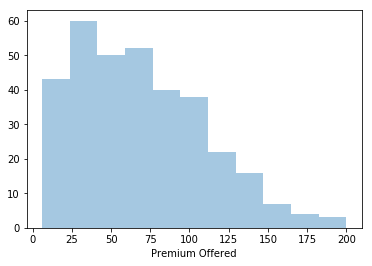

In [60]:
sns.distplot(pd.Series(opt_premiums_nn_clf),kde=False)
_ = plt.xlabel('Premium Offered')

Our Neural Network captures 335 buyers and offers them premiums in a range from 1 to 200 monetary units, being those between 1 and 100 more frequent than those which are higher.

Overall we get 23160 monetary units, which is much better than the result obtained by offering random premiums (between 7800 and 11000 monetary units).

We get 69 monetary units per customer on average, which is much higher than what we got for already contacted clients (14 mu).

These results look like those from the logistic regression: they might be a bit too optimistic considering that for some clients we hit the upper limit from our optimization range, which is really high compared to previously existing prices.

## 4. Conclusion and plots

Among all tested options, logistic regression and neural network classifiers are the only models that behave well with respect to the premium optimization task. SVM and tree-based algorithms fail at reproducing realistic behaviors for feature values that are out of range compared to the training data.

We will use the logistic regression algorithm for supporting our analysis and for business prospect. This decision is backed by two reasons:
- First, the logistic regression captures a higher number of potential buyers and pushes the premium price a bit further, providing a slightly higher benefit (this pushing further might be excessive and counter-productive in reality, but we will assume it is ok for this analysis).
- Second, the logistic regression classifier is a linear model simply based on a series of coefficients, which makes it transparent: we can know why it responds in some way or another to variation of feature values, as opposed to the neural network, which is a "black-box" due to its non-linear stages.

In [11]:
df_lr_coefs = pd.DataFrame(dict(coef_val=lr_chosen.coef_[0],coef_name=list(X_train_f_log.columns)))
df_lr_coefs['coef_val_abs'] = abs(df_lr_coefs['coef_val'])
df_lr_coefs = df_lr_coefs.sort_values(by='coef_val_abs',ascending=False).head(12)

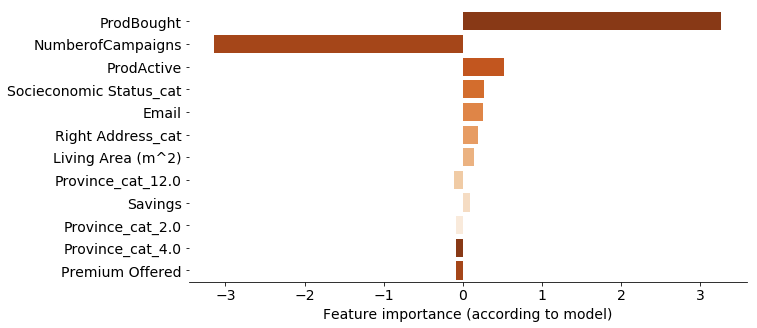

In [85]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='coef_val',y='coef_name',orient='h',data=df_lr_coefs,palette=reversed(sns.color_palette("Oranges", 10)),ax=ax)
ax.set_xlabel('Feature importance (according to model)', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig("model_coefs.svg", bbox_inches='tight')

Our logistic regression model assigns a lot of weight to features related with active products and previous campaigns, which is coherent with what we saw during the exploratory data analysis stage.

Socioecomic Status and available contact information (email and address) also have some decent importance.

We have to go down to the 12th place in feature importance to find the influence of Premium Offered, which is negative (this makes sense, since we expect a lower sale probability for higher premiums). The difference in importance between this features and the top ones is what makes the model predict that many people will not buy not matter what premium they are offered, but then again, this is what the training data depicts.

### Dataset with optimized premiums

We will finally assemble a dataframe using our imputed DB_10000 dataset (withou dummy columns for province), selecting only those clients who bought the premium according to our predictive model, and appending the optimized premium.

Considering those clients who did not buy would not make sense, since we cannot define a value of Premium Offered for them (we tried all values from 1 to 200 and the outcome was always negative)

In [82]:
db_10k_optim = db_10k_imp_nd.iloc[opt_clients_lr_best]
db_10k_optim['Sales'] = 1
db_10k_optim['Premium Offered'] = opt_premiums_lr_best
db_10k_optim.head(2)

,Living Area (m^2),House Price,Income,House Insurance,Pension Plan,Estim. num. cars_cat,Proba. Sec. Res._cat,Credit,Savings,yearBuilt,Socieconomic Status_cat,Province_cat,Right Address_cat,Type of House_cat,PhoneType_cat,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Price Sensitivity,Sales,Premium Offered
index,,,,,,,,,,,,,,,,,,,,,,,
21,309.272,211664.505195,57768.51591,7358.3694,37052.077896,1.0,0.0,16900.457562,52285.85532,2004.0,3.0,28.0,0.0,1.0,0.0,1.0,2005.0,14.0,0.0,3.0,1.0,1,104.520202
118,53.332,168807.767895,45999.39771,5845.1994,29542.235496,0.0,0.0,13453.776162,40874.65632,1975.0,3.0,31.0,0.0,1.0,1.0,0.0,2011.0,6.0,1.0,1.0,6.0,1,5.020202


We will also select those clients with positive sale from DB_20000 for making comparisons

In [83]:
db_20k_sale = db_20k_imp_nd[db_20k_imp_nd['Sales'] == 1]
db_20k_sale.head(2)

,Living Area (m^2),House Price,Income,House Insurance,Pension Plan,Estim. num. cars_cat,Proba. Sec. Res._cat,Credit,Savings,yearBuilt,Socieconomic Status_cat,Province_cat,Right Address_cat,Type of House_cat,PhoneType_cat,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Price Sensitivity,Sales,Premium Offered
index,,,,,,,,,,,,,,,,,,,,,,,
1,85.60244,103235.979015,27854.157114,3485.5758,18037.38088,0.0,0.0,8133.08226,0.0,1998.0,1.0,6.0,0.0,0.0,1.0,0.0,2011.0,2.0,0.0,1.0,5.0,1,11.12
5,118.08404,170171.901315,46198.509714,5854.6278,29799.41848,0.0,0.0,13516.27566,0.0,1980.0,1.0,18.0,1.0,1.0,1.0,1.0,2009.0,6.0,2.0,2.0,5.0,1,14.50


These to datasets would be used for feeding a dashboard.